<a href="https://colab.research.google.com/github/saidileep-knv/Multi-Class-Image-Classification/blob/master/Multi_class_image_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
os.chdir("./drive/My Drive/Colab Notebooks/multi_class_weather_dataset_for_image_classification")

In [ ]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [ ]:
import warnings
warnings.filterwarnings("ignore")
from fastai.vision import *
from fastai.metrics import error_rate, accuracy

In [ ]:
bs = 64

In [ ]:
!ls

images


In [ ]:
dir = "images"

In [ ]:
fnames = get_image_files(dir)

In [ ]:
fnames[:5]

[PosixPath('images/shine81.jpg'),
 PosixPath('images/shine82.jpg'),
 PosixPath('images/shine83.jpg'),
 PosixPath('images/shine84.jpg'),
 PosixPath('images/shine85.jpg')]

In [ ]:
np.random.seed(999)

In [ ]:
pat = r'/([\D]+)\d+\.jpg$'

Create an 'ImageDataBunch' object that pulls the data and performs the necessary transformations on the images.

In [ ]:
data = ImageDataBunch.from_name_re(dir, fnames, pat, ds_tfms=get_transforms(),
                                   size=224, bs=bs).normalize(imagenet_stats)
#All the images are normalized to a size of 224 pixels by 224 pixels                                   

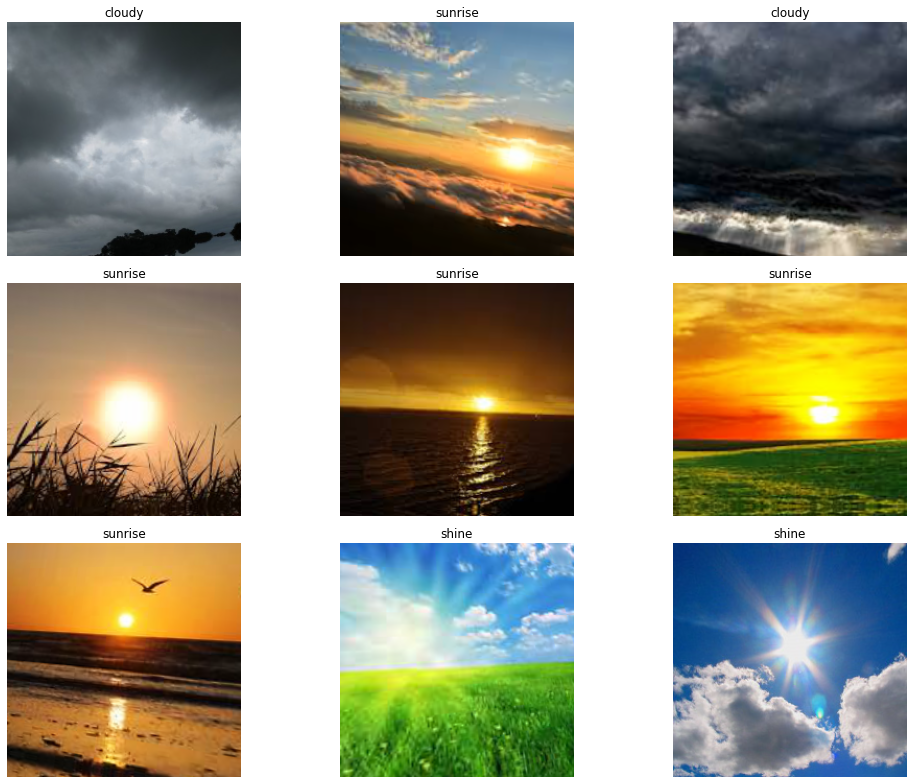

In [ ]:
#show a random batch of images using the show_batch method.
data.show_batch(rows = 3, figsize=(15, 11))

In [ ]:
#Check the classes and the count of classes in the dataset
print("Classes in the dataset:{} and the count is {}.".format(data.classes, data.c))

Classes in the dataset:['cloudy', 'rain', 'shine', 'sunrise'] and the count is 4.


The model being trained is referred to as learner in fastai. Here, we are trying to use the cnn_learner and ResNet34 architecture.

The ResNet architecture is pretrianed on ImageNet dataset. Here, our motivation is to use a pre-trained network and adjust one or more layers since the low-level features are universal and only the high-level features are more related to objects in the dataset. This is referred to as Transfer Learning.

In [ ]:
learn = cnn_learner(data, models.resnet34, metrics=[error_rate, accuracy])

In [ ]:
learn.model

Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  

Layers can be trained using "fit" or "fit_one_cycle", where the former method uses the constant learning rate while the latter method changes the learning rate over time to achieve better results using a "1 cycle policy".

When using a pretrained network, the idea is to train the last layer freezing the rest of the pre-trained feature layers. This is exactly what is being achieved on using the fit_one_cycle method.

In [ ]:
learn.fit_one_cycle(4)

epoch,train_loss,valid_loss,error_rate,accuracy,time
0,1.184830,0.270041,0.084444,0.915556,00:23
1,0.623328,0.133044,0.035556,0.964444,00:24
2,0.429007,0.129309,0.035556,0.964444,00:24
3,0.331725,0.127745,0.035556,0.964444,00:23


In [ ]:
#save the model
learn.save('MCIC-stage-1')

In [ ]:
#Build a classification interpretation object from the learn model
interp = ClassificationInterpretation.from_learner(learn)

losses,idxs = interp.top_losses()

len(data.valid_ds)==len(losses)==len(idxs)

True

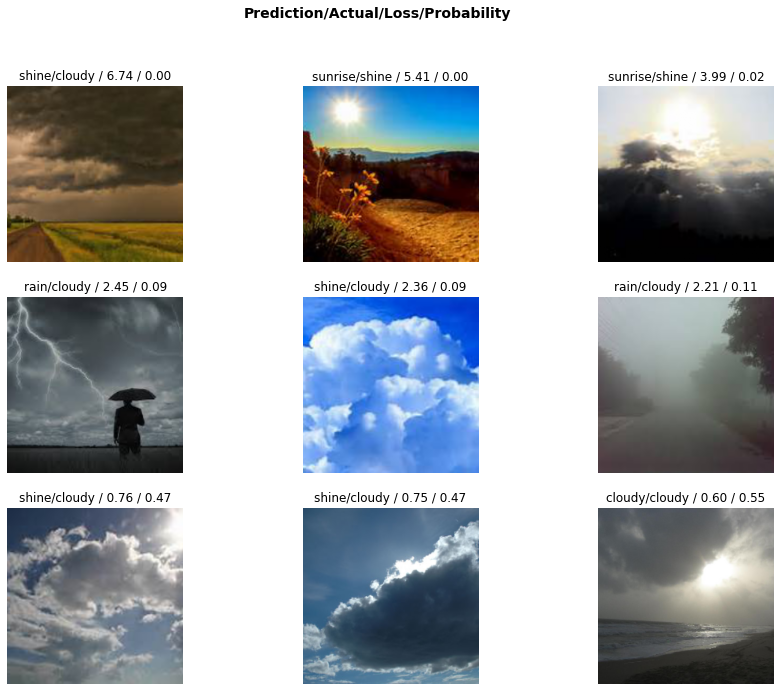

In [ ]:
#Show the top 9 images with the highest loss
interp.plot_top_losses(9, figsize=(15,11))

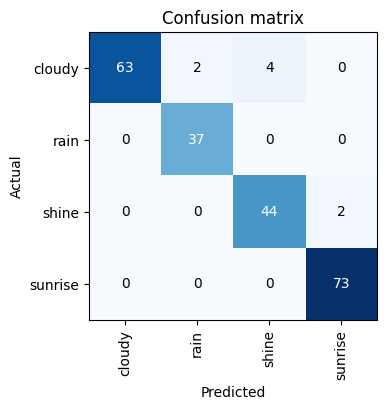

In [ ]:
interp.plot_confusion_matrix(dpi=100)

In [ ]:
interp.most_confused(min_val=2)

[('cloudy', 'shine', 4), ('cloudy', 'rain', 2), ('shine', 'sunrise', 2)]

In [ ]:
#Unfreeze the other layers to train the network on the target data
learn.unfreeze()
learn.fit_one_cycle(1)

epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.254923,0.147384,0.031111,0.968889,00:24


In [ ]:
learn.load('MCIC-stage-1');

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 6.92E-06
Min loss divided by 10: 1.20E-04


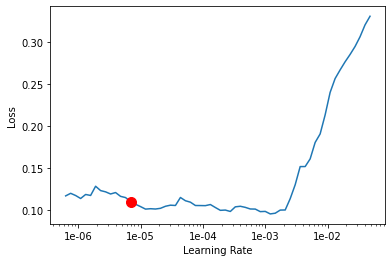

In [ ]:
learn.lr_find()
learn.recorder.plot(suggestion=True)

In [ ]:
learn.unfreeze()
learn.fit_one_cycle(4, max_lr=slice(1e-4,1e-3))

epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.146102,0.240832,0.040000,0.960000,00:24
1,0.134212,0.148051,0.040000,0.960000,00:24
2,0.122341,0.094925,0.026667,0.973333,00:24
3,0.100762,0.036660,0.013333,0.986667,00:25


In [ ]:
learn.save('MCIC-stage-1-50')

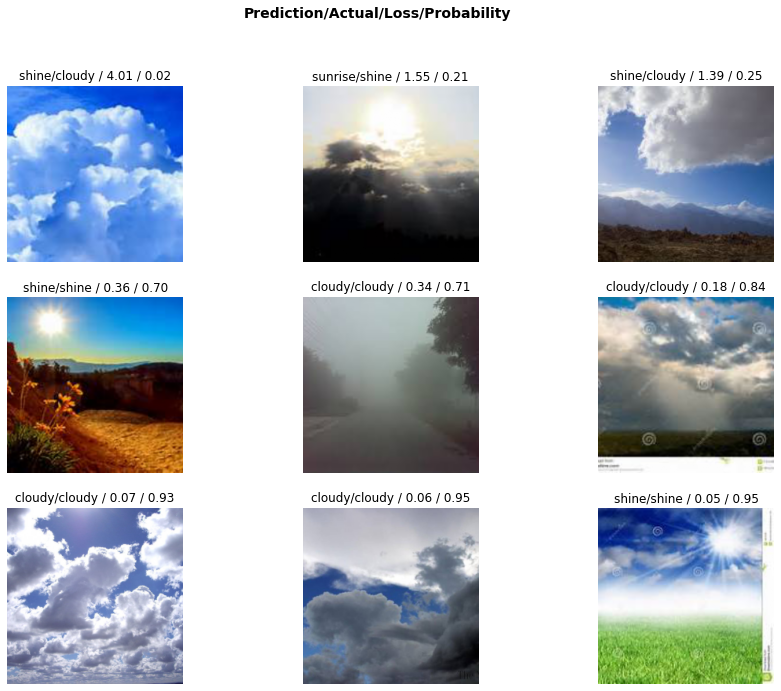

In [ ]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_top_losses(9, figsize=(15,11))

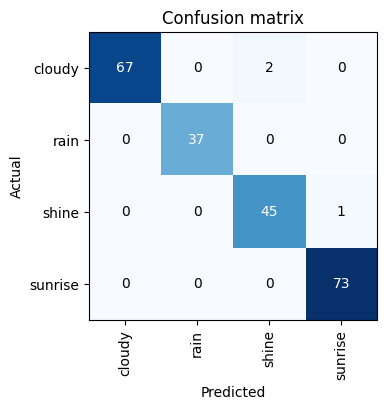

In [ ]:
interp.plot_confusion_matrix(dpi=100)

In [ ]:
learn.load('MCIC-stage-1-50')

Learner(data=ImageDataBunch;

Train: LabelList (900 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
shine,shine,shine,shine,shine
Path: images;

Valid: LabelList (225 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
sunrise,sunrise,shine,cloudy,rain
Path: images;

Test: None, model=Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_st

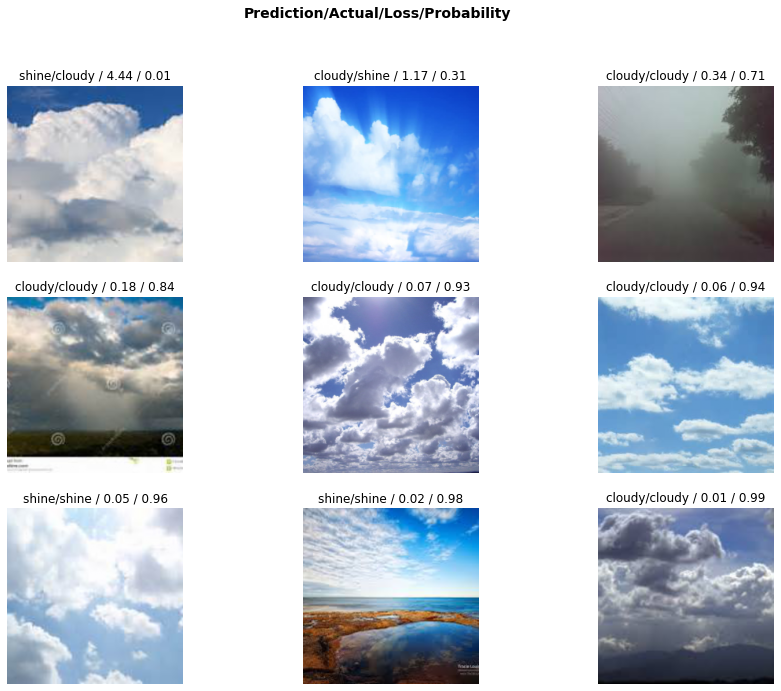

In [ ]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_top_losses(9, figsize=(15,11))

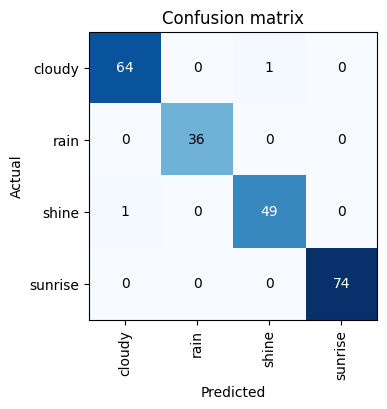

In [ ]:
interp.plot_confusion_matrix(dpi=100)

In [ ]:
#Export the trained model for Web app usage.
learn.export('MCIC_Fastai_Model.pkl')

In [ ]:
learn.summary()

Sequential
Layer (type)         Output Shape         Param #    Trainable 
Conv2d               [64, 112, 112]       9,408      False     
______________________________________________________________________
BatchNorm2d          [64, 112, 112]       128        True      
______________________________________________________________________
ReLU                 [64, 112, 112]       0          False     
______________________________________________________________________
MaxPool2d            [64, 56, 56]         0          False     
______________________________________________________________________
Conv2d               [64, 56, 56]         36,864     False     
______________________________________________________________________
BatchNorm2d          [64, 56, 56]         128        True      
______________________________________________________________________
ReLU                 [64, 56, 56]         0          False     
___________________________________________________